# 안개 발생 진단 분류 모델 생성

## 데이터 설명
- 컬럼

    - `Year` : 년도
    - `Month` : 월
    - `Day` : 일
    - `Time` : 시간 (0 ~ 23)
    - `Minute` : 분 (10분 단위)
    - `STN_ID` : 지점 번호
    - `WS10(deg)` : 10분 평균 풍향, 단위: deg
    - `WS10(m/s)` : 10분 평균 풍속, 단위: m/s
    - `TA` : 1분 평균 기온 10분 주기, 단위: C
    - `RE` : 강수 유무 (0:무강수, 1:강수)
    - `HM` : 1분 평균 상대 습도 10분 주기, 단위: %
    - `sun10` : 1분 일사량 10분단위 합계, 단위: MJ
    - `TS` : 1분 평균 지면온도 10분 주기, 단위: C
    - `VIS1` : 1분 평균 시정 10분 주기, 단위: C (VIS1 변수는 시정 구간을 알 수 있는 변수로 검증 데이터에서는 제외)
    - `class` : 시정 구간

- 시정 계급 기준 (비고: 안개의 기준)

    - `1` : 0 < 시정 < 200
    - `2` : 200 <= 시정 < 500
    - `3` : 500 <= 시정 < 1000
    - `4` : 1000 <= 시정


## 데이터 불러오기

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer


import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터셋 경로 지정
train_path = "../fog_data/fog_train.csv"
test_path = "../fog_data/fog_test.csv"

In [3]:
# 데이터셋 불러오기
fog_train_df = pd.read_csv(train_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)
fog_test_df = pd.read_csv(test_path, index_col=0).rename(columns=lambda x: x.split('.')[1]).reset_index(drop=True)

In [4]:
fog_train_df.head(3)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class
0,I,1,1,0,10,AA,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,20000,4
1,I,1,1,0,20,AA,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,20000,4
2,I,1,1,0,30,AA,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,20000,4


In [5]:
fog_test_df.head(3)

,year,month,day,time,minute,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,L,1,1,0,0,AI,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
1,L,1,1,0,10,AI,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
2,L,1,1,0,20,AI,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN


In [6]:
# fog_train_df[fog_train_df.eq(-99.9).any(axis=1)]

## Preprocessing

### 컬럼 수정 및 제거 

In [7]:
def modify_columns(train_df, test_df):

    # stn_id 수정 : A, B, C, D, E로 수정
    train_df["stn_id"] = train_df["stn_id"].apply(lambda x: x[0])
    test_df["stn_id"] = test_df["stn_id"].apply(lambda x: x[0])

    # year, month, day, time, minute, 컬럼 drop
    train_df.drop(columns=["year", "month", "day", "time", "minute", "vis1"], inplace=True)
    test_df.drop(columns=["year", "month", "day", "time", "minute"], inplace=True)

    return train_df, test_df

In [8]:
train_df, test_df = modify_columns(fog_train_df, fog_test_df)

In [9]:
train_df.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,A,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,4
1,A,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,4
2,A,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,4


In [10]:
test_df.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,A,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
1,A,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
2,A,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN


### 결측치 확인
- `-99` 데이터
- `-99.9` 데이터

In [11]:
# train, test 데이터셋에서 -99 포함한 컬럼들 동일한지 확인
train_df.columns[train_df.isin([-99]).any()] == test_df.columns[test_df.isin([-99]).any()]

array([ True])

In [12]:
# train, test 데이터셋에서 -99.9 포함한 컬럼들 동일한지 확인
train_df.columns[train_df.isin([-99.9]).any()] == test_df.columns[test_df.isin([-99.9]).any()]

array([ True,  True,  True,  True,  True,  True,  True])

In [13]:
# train, test 데이터셋에서 -99, -99.9 포함한 컬럼 동일하기 때문에 같이 변수로 선언
cols_99 = train_df.columns[train_df.isin([-99]).any()].tolist()
cols_99_9 = train_df.columns[train_df.isin([-99.9]).any()].tolist()

In [14]:
# -99, -99.9 인 값을 컬럼 별로 찾아 np.nan으로 변경
def switch_nan(df, cols):
    for col in cols:
        df.loc[df[col]==-99, col] = np.nan
        df.loc[df[col]==-99.9, col] = np.nan
    return df

In [15]:
# train_df의 컬럼 별로 -99, -99.9 인 값들 찾아서 np.nan으로 치환
train_df = switch_nan(train_df, cols_99)
train_df = switch_nan(train_df, cols_99_9)

# test_df의 컬럼 별로 -99, -99.9 인 값들 찾아서 np.nan으로 치환
test_df = switch_nan(test_df, cols_99)
test_df = switch_nan(test_df, cols_99_9)

In [16]:
train_df.isnull().sum()

stn_id          0
ws10_deg     5910
ws10_ms      5826
ta           3867
re          15228
hm           3616
sun10       43910
ts          88639
class       22516
dtype: int64

In [17]:
test_df.isnull().sum()

stn_id           0
ws10_deg       224
ws10_ms        224
ta              91
re            4503
hm              57
sun10          115
ts            7643
class       262800
dtype: int64

In [18]:
# def check_rate(train_df, test_df):
#     # 결측치 확인

#     # train_df에서 -99인 데이터
#     class_99_tr = train_df[train_df.eq(-99).any(axis=1)].shape[0]
#     # train_df에서 -99.9인 데이터
#     class_99_9_tr = train_df[train_df.eq(-99.9).any(axis=1)].shape[0]

#     total_cnt_tr = train_df.shape[0]
#     class_99_pct_tr = round((class_99_tr/total_cnt_tr)*100, 1)
#     class_99_9_pct_tr = round((class_99_9_tr/total_cnt_tr)*100, 1)

#     # test_df에서 -99인 데이터
#     class_99_test = test_df[test_df.eq(-99).any(axis=1)].shape[0]
#     class_99_9_test = test_df[test_df.eq(-99.9).any(axis=1)].shape[0]

#     total_cnt_test = test_df.shape[0]
#     class_99_pct_test = round((class_99_test/total_cnt_test)*100, 1)
#     class_99_9_pct_test = round((class_99_9_test/total_cnt_tr)*100, 1)
   
#     df_99 = pd.DataFrame({"train_nan_cnt" : [class_99_tr, class_99_9_tr],
#                           "train_total" :[total_cnt_tr, total_cnt_tr], 
#                           "test_nan_cnt" : [class_99_test, class_99_9_test],
#                           "test_total": [total_cnt_test, total_cnt_test], 
#                           "train_pct (%)":[class_99_pct_tr, class_99_9_pct_tr], 
#                           "test_pct (%)":[class_99_pct_test, class_99_9_pct_test]}, 
#                           index=["-99", "-99.9"])
#     return df_99

In [19]:
def nan_rate_by_cols(train_df, test_df):
    # 컬럼별 결측치 확인

    # train_df에서 np.nan인 데이터
    nan_tr = train_df.isnull().sum()
    nan_tr_cnt = train_df.isnull().count()

    # test_df에서 np.nan인 데이터
    nan_test = test_df.isnull().sum()
    nan_test_cnt = test_df.isnull().count()

    nan_tr_pct = round((nan_tr/nan_tr_cnt)*100, 1)
    nan_test_pct = round((nan_test/nan_test_cnt)*100, 1)
        
    missing = pd.concat([nan_tr, nan_tr_pct, nan_test, nan_test_pct], 
                        keys=["train_nan", "train_nan_pct", "test_nan", "test_nan_pct"], axis=1)
    return missing

In [20]:
missing = nan_rate_by_cols(train_df, test_df)
missing_sum = pd.DataFrame({"train_nan" : np.sum(missing["train_nan"]),
                            "train_nan_pct" : (np.sum(missing["train_nan"]) / train_df.shape[0])*100,
                            "test_nan" : np.sum(missing["test_nan"])-missing.loc["class", "test_nan"],
                            "test_nan_pct" : ((np.sum(missing["test_nan"])-missing.loc["class", "test_nan"]) / test_df.shape[0]*100)},
                            index=["sum"])
missing_total = pd.concat([missing, missing_sum])

In [21]:
missing

,train_nan,train_nan_pct,test_nan,test_nan_pct
stn_id,0,0.0,0,0.0
ws10_deg,5910,0.2,224,0.1
ws10_ms,5826,0.2,224,0.1
ta,3867,0.1,91,0.0
re,15228,0.5,4503,1.7
hm,3616,0.1,57,0.0
sun10,43910,1.4,115,0.0
ts,88639,2.8,7643,2.9
class,22516,0.7,262800,100.0


In [22]:
# train, test 데이터셋 결측치 데이터프레임 생성
missing_total

,train_nan,train_nan_pct,test_nan,test_nan_pct
stn_id,0,0.000000,0,0.000000
ws10_deg,5910,0.200000,224,0.100000
ws10_ms,5826,0.200000,224,0.100000
ta,3867,0.100000,91,0.000000
re,15228,0.500000,4503,1.700000
hm,3616,0.100000,57,0.000000
sun10,43910,1.400000,115,0.000000
ts,88639,2.800000,7643,2.900000
class,22516,0.700000,262800,100.000000
sum,189512,6.003943,12857,4.892314


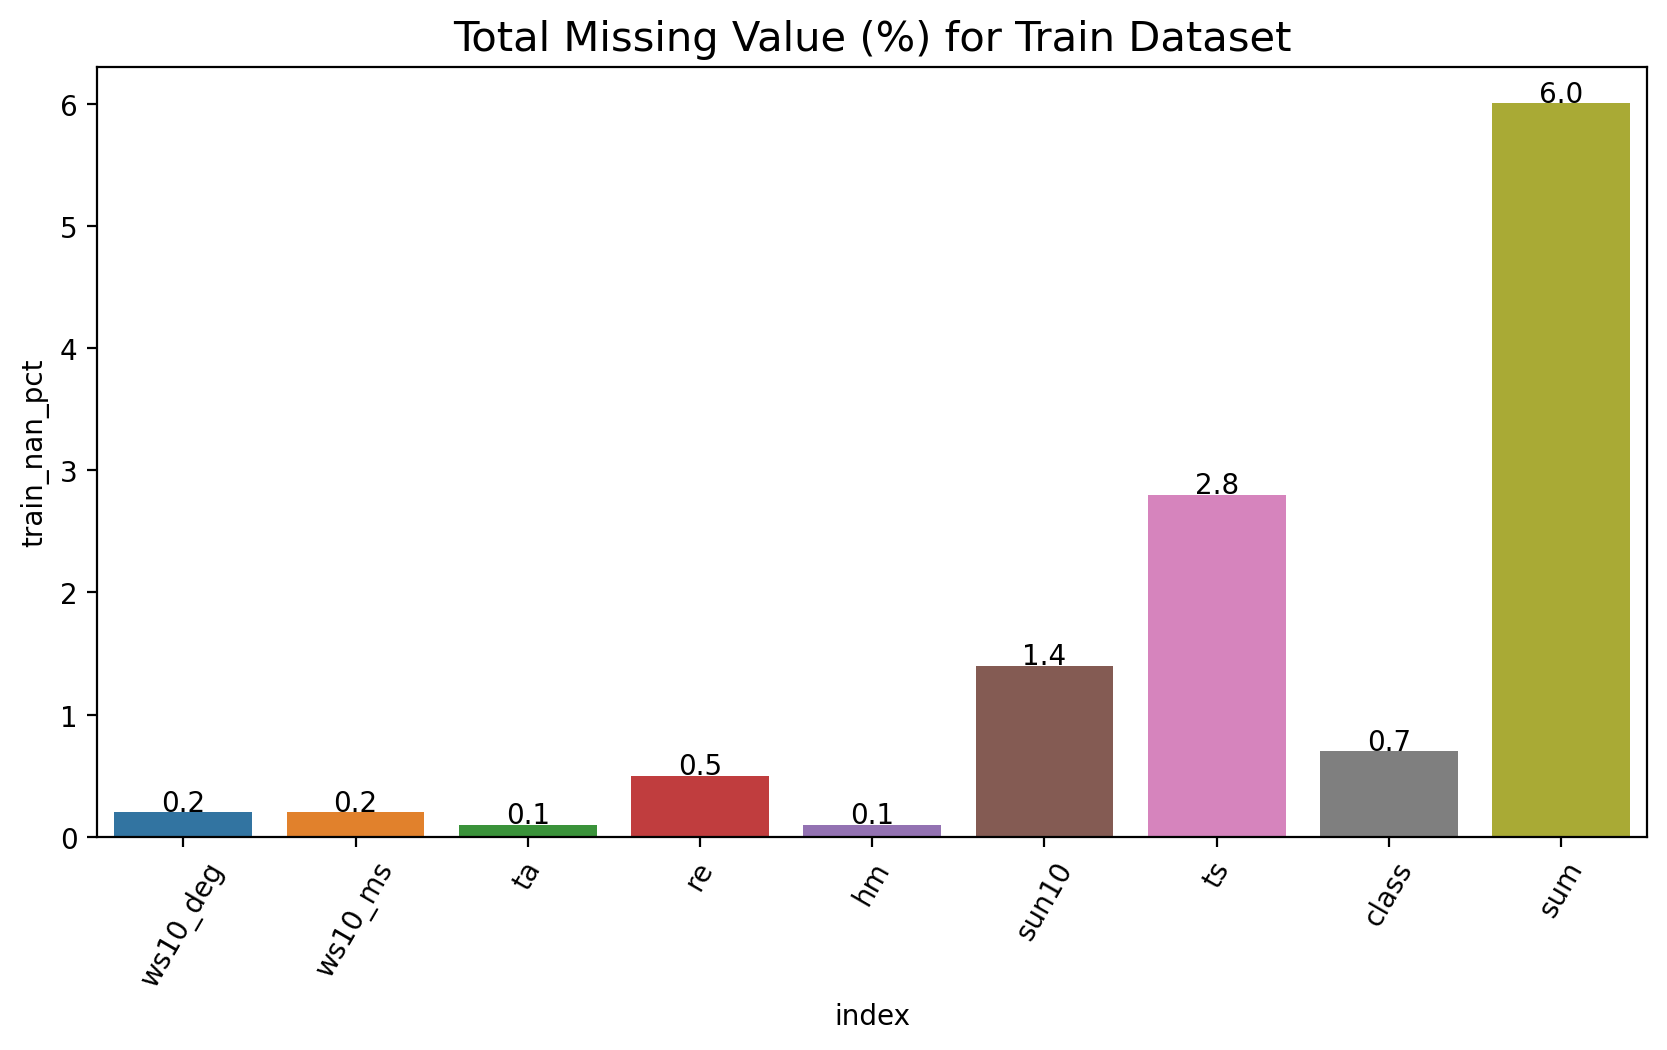

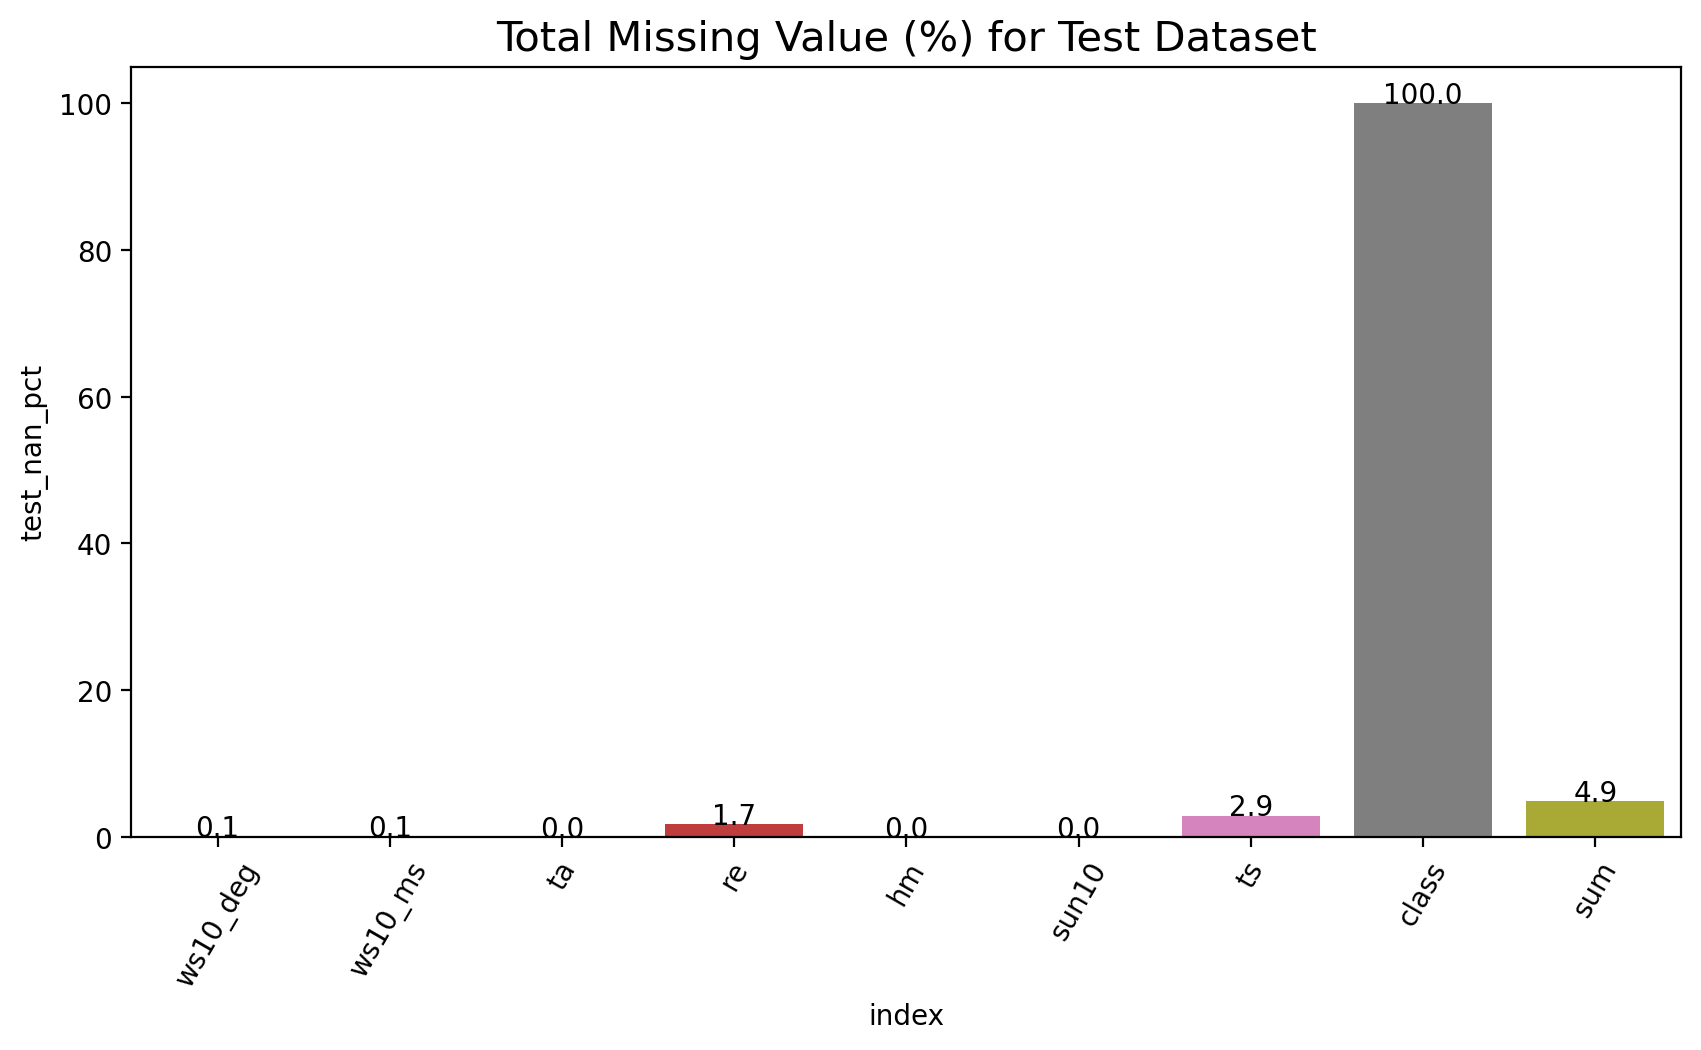

In [23]:
# 결측치 비율 시각화
plt.figure(figsize=(10, 5))
sns_pct = sns.barplot(x="index", y="train_nan_pct", data=missing_total[missing_total["train_nan"]!=0].reset_index())
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=60)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                   # .get_height() : y좌표

    plt.text(bar.get_x() + bar.get_width()/2,   # 퍼센트 글자 위치
             height+0.01,                        # 퍼센트 글자 높이
             "%.1f" % height,                   # 퍼센트 소수점 지정
             ha="center")                       # 가운데 정렬

# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Total Missing Value (%) for Train Dataset", fontsize=15)
# plt.show()

# 결측치 비율 시각화
plt.figure(figsize=(10, 5))
sns_pct = sns.barplot(x="index", y="test_nan_pct", data=missing_total[missing_total["test_nan"]!=0].reset_index())
sns_pct.set_xticklabels(sns_pct.get_xticklabels(), rotation=60)

# bar 그래프 상단에 비율 (%) 표기
for bar in sns_pct.patches:
    height = bar.get_height()                   # .get_height() : y좌표

    plt.text(bar.get_x() + bar.get_width()/2,   # 퍼센트 글자 위치
             height+0.01,                        # 퍼센트 글자 높이
             "%.1f" % height,                   # 퍼센트 소수점 지정
             ha="center")                       # 가운데 정렬

# 시각화 제목 이름, 폰트 크기 지정
sns_pct.set_title("Total Missing Value (%) for Test Dataset", fontsize=15)
plt.show()

#### 결측치 비율에 따른 결측치 처리 방법 선택
- 결측치 비율 `10% 미만` : 제거 또는 대체
- 결측치 비율 `10% 이상 20% 미만` : 모델 기반 처리
- 결측치 비율 `20% 이상` : 모델 기반 처리
- 출처 : https://cheris8.github.io/data%20analysis/DP-NA-Imputation/

### 결측치 제거

In [24]:
# train 데이터셋 결측치 제거
train_df.dropna(inplace=True)

In [25]:
train_df.isnull().sum()

stn_id      0
ws10_deg    0
ws10_ms     0
ta          0
re          0
hm          0
sun10       0
ts          0
class       0
dtype: int64

## 모델링

### 데이터 분리

#### Train, Validation 데이터 분리

In [26]:
# Target 컬럼 : class
target = "class"

# train_df의 컬럼들 중 target (class) 제외한 컬럼들 features에 선언
features = train_df.drop(columns=[target]).columns

In [27]:
# validation 데이터셋 생성
# stratify=train_df[target] : validation 데이터의 분류 target 비율을 train 데이터와 같게 맞춰준다
train, val = train_test_split(train_df, train_size=0.75, random_state=42, stratify=train_df[target])

In [28]:
# train, validation 데이터셋 shape 확인
train.shape, val.shape

((2246137, 9), (748713, 9))

In [29]:
train[target].value_counts(normalize=True)

class
4.0    0.989408
2.0    0.003998
3.0    0.003987
1.0    0.002607
Name: proportion, dtype: float64

In [30]:
val[target].value_counts(normalize=True)

class
4.0    0.989408
2.0    0.003999
3.0    0.003987
1.0    0.002606
Name: proportion, dtype: float64

### 인코딩

#### Label Encoding

In [31]:
# stn_id를 각각 1 ~ 5로 정한 딕셔너리 생성
stn_id_map = {"A" : 1,
              "B" : 2,
              "C" : 3,
              "D" : 4,
              "E" : 5}

In [32]:
# Label Encoding 적용을 위해 train, val, test 데이터 copy()
train_labeled = train.copy()
val_labeled = val.copy()
test_labeled = test_df.copy()

In [33]:
# stn_id_map을 바탕으로 stn_id 컬럼 mapping
train_labeled["stn_id"] = train_labeled["stn_id"].map(stn_id_map)
val_labeled["stn_id"] = val_labeled["stn_id"].map(stn_id_map)
test_labeled["stn_id"] = test_labeled["stn_id"].map(stn_id_map)

In [34]:
train_labeled.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
1607733,2,123.1,1.1,27.5,0.0,79.8,0.0,28.3,4.0
2957173,4,18.5,3.2,6.8,0.0,81.2,0.0,5.9,4.0
1260005,1,0.0,1.3,-3.8,0.0,83.3,0.0,-2.0,4.0


In [35]:
val_labeled.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
1616787,2,103.6,2.5,20.7,0.0,60.8,0.00,19.8,4.0
3132351,5,287.0,6.2,29.1,0.0,59.8,0.24,37.8,4.0
244330,1,263.4,2.6,29.9,0.0,73.9,0.06,31.6,4.0


In [36]:
test_labeled.head(3)

,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class
0,1,329.5,0.6,-2.5,0.0,87.5,0.0,-1.6,NaN
1,1,321.8,1.2,-2.5,0.0,88.2,0.0,-1.6,NaN
2,1,0.4,0.4,-2.5,0.0,88.6,0.0,-1.7,NaN


#### X, y 데이터 분리

In [37]:
# train, validation, test 데이터 나눠준다
X_train_labeled = train_labeled[features]
y_train_labeled = train_labeled[target]

# validation 데이터 나눠준다
X_val_labeled = val_labeled[features]
y_val_labeled = val_labeled[target]

# test 데이터 나눠준다 (class 제거)
X_test_labeled = test_labeled[features]

In [38]:
X_train_labeled.shape, y_train_labeled.shape, X_val_labeled.shape, y_val_labeled.shape, X_test_labeled.shape

((2246137, 8), (2246137,), (748713, 8), (748713,), (262800, 8))

### Baseline 모델 생성

In [39]:
# 의사결정나무 모델로 Baseline 모델 생성
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_labeled, y_train_labeled)

DecisionTreeClassifier(random_state=42)

In [40]:
y_val_pred = dt.predict(X_val_labeled)

accuracy_score(y_val_labeled, y_val_pred)

0.9858864478111106

In [46]:
precision_score(y_val_labeled, y_val_pred, average="weighted")

0.986850322141096

In [56]:
f1_score(y_val_labeled, y_val_pred, average="weighted")


0.9863581658243882

In [48]:
# CSI 지수 함수 생성
def csi_index(y_true, y_pred):
    
    model_cm = confusion_matrix(y_true, y_pred)

    H = (model_cm[0][0] + model_cm[1][1] + model_cm[2][2])
    F = (model_cm[0][1] + model_cm[0][2] + 
            model_cm[1][0] + model_cm[1][2] + 
            model_cm[2][0] + model_cm[2][1] +
            model_cm[3][0] + model_cm[3][1] + model_cm[3][2])
    M = (model_cm[0][3] + model_cm[1][3] + model_cm[2][3])

    model_csi = H / (H + F + M)

    return model_csi

csi_scorer = make_scorer(csi_index, greater_is_better=True)

In [60]:
def model_comparison(models, X_train, y_train, X_val, y_val, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        # 트리 기반 모델들은 각 변수의 information gain을 기반으로 판단하기 때문에 굳이 스케일링 해줄 필요가 없다

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # 모델의 Accuracy, Precision, Recall, F1 score 확인
        accuracy = accuracy_score(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred, average="weighted")
        recall = recall_score(y_val, y_val_pred, average="weighted")
        f1_score_ = f1_score(y_val, y_val_pred, average="weighted")
        csi_index_ = csi_index(y_val, y_val_pred)
        # rootMeanSqLogErr = get_rmsle(y_val, y_val_pred)

        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                               "Accuracy" : np.round(accuracy, 4),
                               "Precision" : np.round(precision, 4),
                               "Recall" : np.round(recall, 4),
                               "F1 Score" : np.round(f1_score_, 4),
                               "CSI Index" : np.round(csi_index_, 4)
                               # "Accuracy" : '{:.2f}'.format(accuracy),
                               # "Precision" : '{:.2f}'.format(precision),
                               # "Recall" : '{:.2f}'.format(recall),
                               # "F1 Score" : '{:.2f}'.format(f1_score_),
                               # "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))
                               })
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    # return models_df.sort_values(by=["RMSLE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)
    return models_df.sort_values(by=["CSI Index", "Accuracy", "F1 Score"], 
                                 ascending=[False, True, False]
                                 ).reset_index(drop=True)


In [61]:
baseline_model = [("Decision Tree", DecisionTreeClassifier(random_state=42))]
model_comparison(baseline_model, X_train_labeled, y_train_labeled, X_val_labeled, y_val_labeled)


====== Models Before Hyper Parameter Tuning ======


,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9859,0.9869,0.9859,0.9864,0.1862


### 하이퍼 파라미터 튜닝 전 모델 생성 (CatBoost, Naive Bayes)

In [71]:
models = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("CatBoost", CatBoostClassifier(random_state=42)),
    ("Naive Bayes", GaussianNB())
]

In [70]:
model_comparison(models, X_train_labeled, y_train_labeled, X_val_labeled, y_val_labeled)


====== Models Before Hyper Parameter Tuning ======


,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9859,0.9869,0.9859,0.9864,0.1862
1,Naive Bayes,0.9425,0.9807,0.9425,0.9606,0.0254


In [72]:
model_comparison(models, X_train_labeled, y_train_labeled, X_val_labeled, y_val_labeled)

Learning rate set to 0.117286
0:	learn: 1.0658520	total: 517ms	remaining: 8m 36s
1:	learn: 0.8640359	total: 977ms	remaining: 8m 7s
2:	learn: 0.7201056	total: 1.38s	remaining: 7m 39s
3:	learn: 0.6105873	total: 1.8s	remaining: 7m 28s
4:	learn: 0.5244112	total: 2.2s	remaining: 7m 17s
5:	learn: 0.4546170	total: 2.66s	remaining: 7m 20s
6:	learn: 0.3972762	total: 3.11s	remaining: 7m 20s
7:	learn: 0.3494981	total: 3.55s	remaining: 7m 19s
8:	learn: 0.3093164	total: 4.01s	remaining: 7m 22s
9:	learn: 0.2751900	total: 4.49s	remaining: 7m 24s
10:	learn: 0.2460184	total: 4.91s	remaining: 7m 21s
11:	learn: 0.2210375	total: 5.33s	remaining: 7m 18s
12:	learn: 0.1994327	total: 5.77s	remaining: 7m 17s
13:	learn: 0.1808550	total: 6.23s	remaining: 7m 18s
14:	learn: 0.1647478	total: 6.65s	remaining: 7m 16s
15:	learn: 0.1507327	total: 7.12s	remaining: 7m 17s
16:	learn: 0.1385349	total: 7.52s	remaining: 7m 14s
17:	learn: 0.1278185	total: 7.92s	remaining: 7m 11s
18:	learn: 0.1183905	total: 8.39s	remaining: 7m

,Model,Accuracy,Precision,Recall,F1 Score,CSI Index
0,Decision Tree,0.9859,0.9869,0.9859,0.9864,0.1862
1,CatBoost,0.9901,0.9866,0.9901,0.9861,0.0789
2,Naive Bayes,0.9425,0.9807,0.9425,0.9606,0.0254
